In [18]:
import pandas as pd  # Data manipulation and analysis library
import numpy as np  # Numerical computing library
import matplotlib.pyplot as plt  # Plotting library for data visualization
import keras  # Deep learning library
import re  # Regular expressions library for string operations
import nltk  # Natural Language Toolkit for text processing
from nltk.corpus import stopwords  # Collection of stop words used in NLP
import string  # String module for common string operations
import json  # Library to work with JSON data
# from tensorflow.keras.utils import load_img #deprecated 
from time import time  # Library to measure time during code execution
import pickle  # Module for serializing and deserializing Python objects
from keras.applications.vgg16 import VGG16  # Pre-trained VGG16 model for image classification
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions  # Pre-trained ResNet50 model for image classification, along with preprocessing and decoding functions
from keras.preprocessing import image  # Utilities for loading and preprocessing images
from keras.models import Model, load_model  # Base class for models and functions to load models
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding sequences to the same length for neural networks
from keras.utils import to_categorical  # Utility for converting labels to categorical format (one-hot encoding)
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM  # Deep learning layers from Keras
from tensorflow.keras.layers import Add  # Layer for adding tensors in neural networks

In [ ]:
#read text captions
def readTextFile(path):
    with open(path) as f:
        captions=f.read()#readlines is also functions
    return captions

In [3]:
import os

# print("current working dir",os.getcwd())
captions=readTextFile("./flickr/Flickr8k.token.txt")
# len(captions.split("\n"))
captions=captions.split("\n")[:-1]

In [4]:
len(captions)

40460

In [4]:
first,second=captions[0].split("\t")#first part is image id and remaining is descritpion
print(first.split(".")[0])#this gives imageid
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [5]:
#Dictionary to Map each image with list of captions it has

descriptions={}

for x in captions:
    first,second=x.split("\t")#image id and descriptn
    img_name=first.split(".")[0]

#if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]#intially image has empty list for captions

    #already present then append descriptio to that list
    descriptions[img_name].append(second)

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

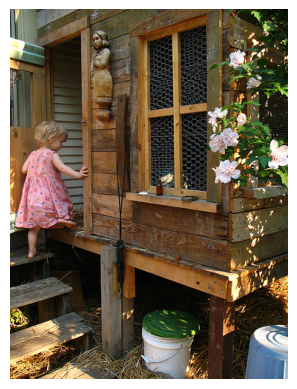

In [6]:
IMG_PATH="./images/Images/"
import cv2 
import matplotlib.pyplot as plt
img=cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

CV2 is the main module in OpenCV, an open source library for computer vision applications. It provides developers with an interface for working with image and video processing functions. CV2 is written in C++ and has interfaces for C++, Python, Java, and MATLAB.

## 1.Data Cleaning

1.as we generate english test to dont remove stop words,dont perform stemming for better trainig of model
2.make allwords lowercase,remove number,punctution,reduce vocab size
3.as less vocabulary which leads to less neurons in dense layer  ,less overfitting,less computation.

In [10]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)#substitute which are not alphabets  
    sentence=sentence.split()

    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [11]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [12]:
#clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [13]:
descriptions["1000268201_693b08cb0e"]#see we remove small words of lenght 1

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
#write the data to text-file
# f=open("descriptions.txt","w")
# f.write(str(descriptions))
# f.close()

with open("descriptions1.txt","w") as f:
    f.write(str(descriptions))

## 2.Creating Vocab

In [18]:
descriptions=None
with open("descriptions1.txt",'r') as f:
    descriptions=f.read()


json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [19]:
print(type(descriptions))

<class 'dict'>


In [20]:
#vocab

vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]#list comprehension

print("vocab size : %d"%len (vocab))#unqiue words in our set

vocab size : 8424


In [22]:
#total no of words across all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
# des is list of captions  and i is word in that particular captionn
print("total words %d"%len(total_words))

total words 373837


In [23]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


filter words from vocab accordng to certain threshold freq

In [32]:
import collections#it is data structure

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(freq_cnt)#frequency of every unique words

{'in': 1, 'the': 1, 'on': 1, 'is': 1, 'and': 1, 'dog': 1, 'with': 1, 'man': 1, 'of': 1, 'two': 1, 'white': 1, 'black': 1, 'boy': 1, 'are': 1, 'woman': 1, 'girl': 1, 'to': 1, 'wearing': 1, 'at': 1, 'people': 1, 'water': 1, 'red': 1, 'young': 1, 'brown': 1, 'an': 1, 'his': 1, 'blue': 1, 'dogs': 1, 'running': 1, 'through': 1, 'playing': 1, 'while': 1, 'shirt': 1, 'down': 1, 'standing': 1, 'ball': 1, 'little': 1, 'grass': 1, 'snow': 1, 'child': 1, 'person': 1, 'jumping': 1, 'over': 1, 'three': 1, 'front': 1, 'sitting': 1, 'holding': 1, 'up': 1, 'field': 1, 'small': 1, 'by': 1, 'large': 1, 'green': 1, 'one': 1, 'group': 1, 'yellow': 1, 'her': 1, 'walking': 1, 'children': 1, 'men': 1, 'into': 1, 'air': 1, 'beach': 1, 'near': 1, 'mouth': 1, 'jumps': 1, 'another': 1, 'for': 1, 'street': 1, 'runs': 1, 'its': 1, 'from': 1, 'riding': 1, 'stands': 1, 'as': 1, 'bike': 1, 'girls': 1, 'outside': 1, 'other': 1, 'off': 1, 'out': 1, 'rock': 1, 'next': 1, 'play': 1, 'orange': 1, 'looking': 1, 'pink': 1, 

In [28]:
#sort dictionary according to freq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])#comparesion based on values of all key/words
#sorted funct operate on list n freq_cnt.items() generate list
#filter
threshold=10 #discard word which freq less than 10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [33]:
print(len(total_words))#we got more than 3 lakh words out of which we got 8400 unique words
#then shortlisted based on threshold.fre we got 1845

1845


## Training : We need to create a training description  of each image and compare it with testing description of image 

## 3.Prepare train/test data

In [5]:
train_file_data=readTextFile("./flickr/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("./flickr/Flickr_8k.testImages.txt")

In [15]:
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [6]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]#row was split bcz 
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]#we extract only imageid and removed .jpg


Prepare Desciption for the training data
Tweak add <s> and <e> token(start,end) to training data


In [ ]:
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:#for each image id we have multiple captions so we are iterating over them and appending to list of that image id
        cap_to_append="startseq " + cap +" endseq"
        train_descriptions[img_id].append(cap_to_append)

In [20]:
train_descriptions["1000268201_693b08cb0e"]#now each sentence have token (s,e)

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer Learning
- Images--->features  get feature from image
- Text--->features get feature from text

### Step-1 Image Feature Extraction
pretrained model used is ResNet-50 (trained on Imagenet)
ResNet50 contains 50 layers
ResNet has skip connection to avoid gradient(vanish) (connected to col describes the flow)

In [ ]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3)) 
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

-resnet used only for feature extraction purposes
-(None, 7, 7, 2048) This is len, width, a depth so a total of 7mul7mul2048 neurons which lead to large parameters so flatten it using GlobalAveragePooling) to 2048 values
-A high activation value means a particular feature present in image, vice-versa

New sequential Model which takes GlobalAveragePooling2 as input

In [8]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [ ]:
model_new=Model(model.input,model.layers[-2].output)#shape will be [m*2048]  #m is no of images and 2048 is no of features in that image 

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array
def preprocess_img(img):
    img=load_img(img,target_size=(224,224))#load image and resize it to 224,224
    img=img_to_array(img)#convert image to array 
    img=np.expand_dims(img,axis=0)#changing dimension from 3d to 4d
    # normalization
    img = preprocess_input(img)#preprocess input is function of resnet50 which normalizes the image acc to resnet50 model 
    return img

In [33]:
# IMG_PATH="./images/Images/"

# img=preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
# plt.imshow(img[0])
# plt.axis("off")
# plt.show()
# print(img)

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector=model_new.predict(img)
    print(feature_vector.shape)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [41]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 0s 236ms/step
(2048,)


array([0.06536551, 0.16782704, 0.32518464, ..., 0.05111536, 0.3281792 ,
       1.0043334 ], dtype=float32)